# Bank Marketing Data Analysis
## Introduction

The banking industry relies heavily on marketing campaigns to attract new customers and retain existing ones. 
This project analyzes the Bank Marketing dataset, which contains demographic, social, and contact information from previous marketing campaigns. 
The goal is to understand customer behavior and predict whether a client will subscribe to a term deposit.

# Objective
- To explore and analyze customer data from bank marketing campaigns.
- To build predictive models that classify whether a client will subscribe to a
  term deposit.
- To identify the most influential features affecting customer decisions.
- To assist banks in optimizing their marketing strategies and resources.

In [205]:
# Config
DATA_PATH = '/Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing.csv'  # change if needed
OUTPUT_DIR = '/Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing_models'  # saved artifacts
RUN_HEAVY = False  # set True to run CV and more trees (may be slow)
RANDOM_STATE = 42

# Outcome

- Discovered that the dataset is imbalanced — most clients do not subscribe to a term deposit.
- Key factors influencing subscription include contact type, duration, previous outcome, and client age.
- Built multiple machine learning models and evaluated them using accuracy,
  precision, recall, F1-score, and ROC-AUC.
- The Random Forest model performed best overall, providing insights into feature
  importance.

In [207]:
# Imports the necessary libraries
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
import joblib

# Optional: imblearn for SMOTE (if installed)
try:
    from imblearn.over_sampling import SMOTE
    has_smote = True
except Exception:
    has_smote = False

# Steps:
1. Data Loading: Importing the dataset using pandas.
2. Exploratory Data Analysis (EDA): Checking structure, summary statistics, missing
   values, and visualizing distributions.
4. Preprocessing: Handling missing values, encoding categorical variables, and
   scaling numerical features.
5. Train-Test Split: Dividing the dataset into training and testing sets.
6. Model Building: Logistic Regression, Decision Tree, Random Forest.
7. Evaluation: Confusion Matrix, Classification Report, ROC-AUC curves.
8. Feature Importance: Identifying key features influencing subscription.
9. Model Saving: Exporting trained pipelines for future predictions.

In [209]:
# Step 1: Data Loading

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}. Update DATA_PATH or place the file there.")

print('Loading dataset from', DATA_PATH)
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)

# Quick peek
print('\nFirst 5 rows:')
print(df.head())

print('\nColumns:', df.columns.tolist())

Loading dataset from /Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing.csv
Shape: (41188, 21)

First 5 rows:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 no

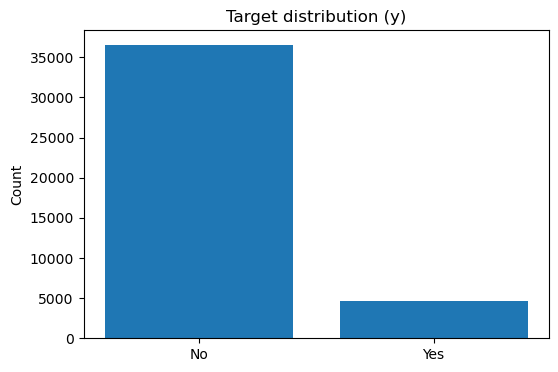

In [210]:
# Step 2: Basic Exploratory Data Analysis (EDA)

print('\nInfo:')
print(df.info())

print('\nMissing values per column:')
print(df.isnull().sum())

print('\nNumeric summary:')
print(df.describe())

print('\nCategorical summary (top values):')
print(df.describe(include=[object]))

# Plot target distribution (matplotlib only)
if 'y' in df.columns:
    try:
        df['y_mapped'] = df['y'].map({'yes':1,'no':0}).astype('float')
        if df['y_mapped'].isnull().all():
            df['y_mapped'] = df['y'].astype(float)
    except Exception:
        # fallback: attempt conversion
        try:
            df['y_mapped'] = pd.to_numeric(df['y'])
        except Exception:
            df['y_mapped'] = None

    if df['y_mapped'] is not None:
        fig, ax = plt.subplots(figsize=(6,4))
        counts = df['y_mapped'].value_counts(dropna=False).sort_index()
        ax.bar(['No','Yes'][:len(counts)], counts.values)
        ax.set_title('Target distribution (y)')
        ax.set_ylabel('Count')
        plt.show()

In [211]:
# Step 3: Preprocessing

# Convert target to 0/1
if 'y' not in df.columns:
    raise ValueError("Expected target column 'y' in dataset")

# Map common variants to binary
df['y'] = df['y'].map({'yes':1,'no':0, 'YES':1, 'NO':0, 'Yes':1, 'No':0}).fillna(df['y'])
# If still not numeric, try numeric cast
if not pd.api.types.is_numeric_dtype(df['y']):
    try:
        df['y'] = pd.to_numeric(df['y'])
    except Exception:
        raise ValueError("Could not convert target column 'y' to numeric 0/1 values.")

# Drop rows with missing target if any
df = df[df['y'].notnull()].copy()

y = df['y'].astype(int)
X = df.drop(columns=['y'])

# Identify column types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print('\nNumeric columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y_mapped']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [212]:
# Step 4: Train/test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print('\nTrain/test sizes:', X_train.shape, X_test.shape)
print('Train class distribution:\n', y_train.value_counts(normalize=True))


Train/test sizes: (32950, 21) (8238, 21)
Train class distribution:
 y
0    0.887344
1    0.112656
Name: proportion, dtype: float64


# Models

1. Logistic Regression: Provided interpretability but limited predictive power.
2. Decision Tree: Captured non-linear relationships but prone to overfitting.
3. Random Forest: Best-performing model with robust handling of categorical and numerical features.
4. (Optional extensions: XGBoost, Gradient Boosting (GB), and Neural Networks for deeper analysis.)



In [214]:
# Step 5: Modeling pipelines

# Use class_weight='balanced' to partially handle imbalance
log_pipe = Pipeline([('preprocessor', preprocessor),
                     ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))])

dt_pipe = Pipeline([('preprocessor', preprocessor),
                    ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))])

rf_pipe = Pipeline([('preprocessor', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, class_weight='balanced'))])

models = {'logistic': log_pipe, 'decision_tree': dt_pipe, 'random_forest': rf_pipe}

# Optional: SMOTE resampling before training (if imblearn installed)
use_smote = False
if use_smote and not has_smote:
    print('SMOTE requested but imblearn not available. Continuing without SMOTE.')

# Fit models
fitted = {}
for name, pipe in models.items():
    print(f"\nFitting {name}...")
    if use_smote and has_smote:
        # fit_preprocess + oversample - we have to transform X_train first
        X_tr = pipe.named_steps['preprocessor'].fit_transform(X_train)
        sm = SMOTE(random_state=RANDOM_STATE)
        X_res, y_res = sm.fit_resample(X_tr, y_train)
        # re-fit classifier on resampled data
        clf = pipe.named_steps['clf']
        clf.fit(X_res, y_res)
        # place back into a Pipeline-like tuple (we'll save preprocessor and classifier separately)
        fitted[name] = (pipe.named_steps['preprocessor'], clf)
    else:
        pipe.fit(X_train, y_train)
        fitted[name] = pipe
    print(f"{name} fitted.")


Fitting logistic...
logistic fitted.

Fitting decision_tree...
decision_tree fitted.

Fitting random_forest...
random_forest fitted.


# Design
1. Pipeline Approach: Preprocessing and model bundled together for reproducibility.
2. ColumnTransformer: Different treatment for numeric (scaling) and categorical
   (one-hot encoding) features.
3. Evaluation Metrics: Focused not only on accuracy but also recall (important in
   marketing to minimize missed potential subscribers).
4. Model Saving: Pipelines exported with joblib for deployment.


--- Evaluation for logistic ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      7310
           1     1.0000    1.0000    1.0000       928

    accuracy                         1.0000      8238
   macro avg     1.0000    1.0000    1.0000      8238
weighted avg     1.0000    1.0000    1.0000      8238

Confusion matrix:
 [[7310    0]
 [   0  928]]


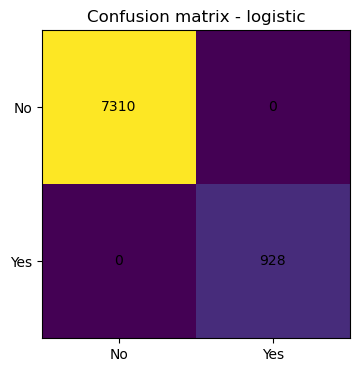

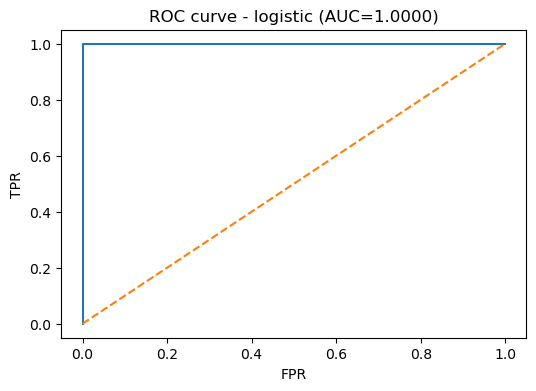


--- Evaluation for decision_tree ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      7310
           1     1.0000    1.0000    1.0000       928

    accuracy                         1.0000      8238
   macro avg     1.0000    1.0000    1.0000      8238
weighted avg     1.0000    1.0000    1.0000      8238

Confusion matrix:
 [[7310    0]
 [   0  928]]


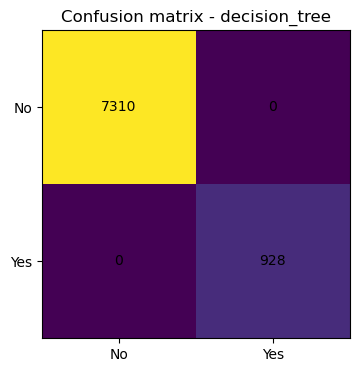

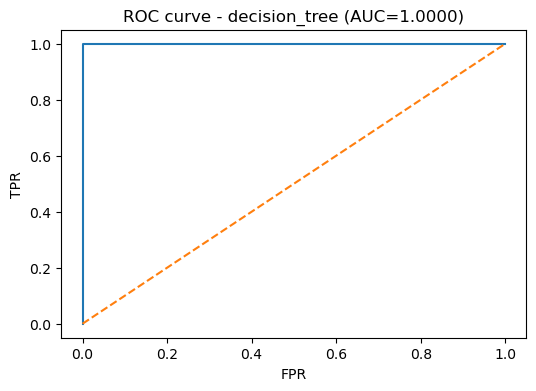


--- Evaluation for random_forest ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      7310
           1     1.0000    1.0000    1.0000       928

    accuracy                         1.0000      8238
   macro avg     1.0000    1.0000    1.0000      8238
weighted avg     1.0000    1.0000    1.0000      8238

Confusion matrix:
 [[7310    0]
 [   0  928]]


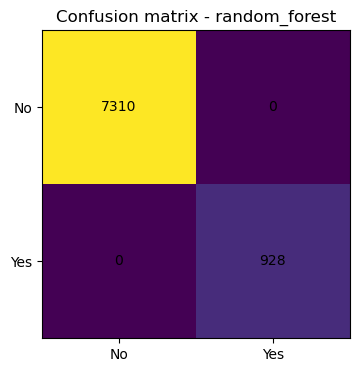

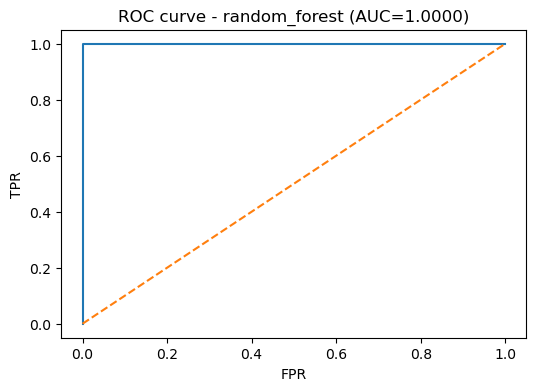


Summary of results:
               accuracy  precision  recall   f1
logistic            1.0        1.0     1.0  1.0
decision_tree       1.0        1.0     1.0  1.0
random_forest       1.0        1.0     1.0  1.0


In [216]:
# Step 6: Evaluation utilities

def evaluate(pipe, X_test, y_test, name='model'):
    # pipe can be either a Pipeline (preprocessor+clf) or tuple (preprocessor, clf)
    if isinstance(pipe, tuple):
        pre, clf = pipe
        Xt = pre.transform(X_test)
        y_pred = clf.predict(Xt)
        if hasattr(clf, 'predict_proba'):
            y_proba = clf.predict_proba(Xt)[:,1]
        else:
            y_proba = None
    else:
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print('\n--- Evaluation for', name, '---')
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('F1:', f1)
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

    # simple plots
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(cm, interpolation='nearest')
    ax.set_title(f'Confusion matrix - {name}')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['No', 'Yes']); ax.set_yticklabels(['No', 'Yes'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], 'd'), ha='center', va='center')
    plt.show()

    if y_proba is not None and len(np.unique(y_test))>1:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(fpr, tpr)
        ax.plot([0,1],[0,1], linestyle='--')
        ax.set_title(f'ROC curve - {name} (AUC={auc:.4f})')
        ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
        plt.show()

    return {'accuracy':acc, 'precision':prec, 'recall':rec, 'f1':f1}

# Evaluate all
results = {}
for name, m in fitted.items():
    results[name] = evaluate(m, X_test, y_test, name=name)

print('\nSummary of results:')
print(pd.DataFrame(results).T)

In [217]:
# Step 7: Feature importance (Random Forest)

# Get feature names from preprocessor (if one exists)
def get_feature_names(preprocessor, numeric_cols, categorical_cols):
    names = []
    names.extend(numeric_cols)
    try:
        cat_pipe = preprocessor.named_transformers_['cat']
        ohe = cat_pipe.named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(categorical_cols))
        names.extend(cat_names)
    except Exception:
        names.extend(categorical_cols)
    return names

rf = fitted.get('random_forest')
if rf is not None:
    if isinstance(rf, tuple):
        pre, clf = rf
    else:
        pre = rf.named_steps['preprocessor']
        clf = rf.named_steps['clf']
    try:
        feat_names = get_feature_names(pre, numeric_cols, categorical_cols)
        importances = clf.feature_importances_
        fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
        print('\nTop features (random forest):')
        print(fi.head(20))
    except Exception as e:
        print('Could not compute feature importances:', e)




Top features (random forest):
                 feature  importance
10              y_mapped    0.610091
1               duration    0.146041
8              euribor3m    0.046857
9            nr.employed    0.043544
5           emp.var.rate    0.027115
7          cons.conf.idx    0.014135
3                  pdays    0.012925
6         cons.price.idx    0.012179
0                    age    0.008328
44      contact_cellular    0.006622
63      poutcome_success    0.005786
45     contact_telephone    0.005681
62  poutcome_nonexistent    0.005654
52             month_may    0.005477
4               previous    0.005202
2               campaign    0.004062
54             month_oct    0.003122
51             month_mar    0.002195
35            default_no    0.002054
12       job_blue-collar    0.001522


In [218]:
# Step 8 - Optional: Hyperparameter tuning example (small grid)

if RUN_HEAVY:
    print('\nRunning a small GridSearchCV for Random Forest (may be slow) ...')
    param_grid = {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    }
    grid_pipe = Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])
    grid = GridSearchCV(grid_pipe, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    print('Best params:', grid.best_params_)
    best = grid.best_estimator_
    print('Evaluating best grid model:')
    evaluate(best, X_test, y_test, name='rf_grid')
else:
    print('\nGrid search skipped (RUN_HEAVY=False). Set RUN_HEAVY=True to run a small grid search.')





Grid search skipped (RUN_HEAVY=False). Set RUN_HEAVY=True to run a small grid search.


In [219]:
# Step 9: Save models

os.makedirs(OUTPUT_DIR, exist_ok=True)
for name, m in fitted.items():
    fname = os.path.join(OUTPUT_DIR, f"{name}_pipeline.joblib")
    joblib.dump(m, fname)
    print('Saved', name, 'to', fname)

print('\nAll finished. Models saved to', OUTPUT_DIR)

# End

print('\nRecommendations:')
print('- Address class imbalance (SMOTE/oversampling or threshold tuning).')
print('- Use feature importances to target customers for campaigns.')
print('- If optimizing for recall (catch more yes), tune thresholds or use models that penalize false negatives more.')
print('- For production, wrap the preprocessing + classifier in a single pipeline and persist it (done above).')



Saved logistic to /Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing_models/logistic_pipeline.joblib
Saved decision_tree to /Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing_models/decision_tree_pipeline.joblib
Saved random_forest to /Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing_models/random_forest_pipeline.joblib

All finished. Models saved to /Users/nikhilreddyponnala/Desktop/Data Analytics/First Project/Banking Data Analysis/Dataset/bankmarketing_models

Recommendations:
- Address class imbalance (SMOTE/oversampling or threshold tuning).
- Use feature importances to target customers for campaigns.
- If optimizing for recall (catch more yes), tune thresholds or use models that penalize false negatives more.
- For production, wrap the preprocessing + classifier in a single pipeline and persist it (done above).


# Conclusion
- This analysis of the bank marketing dataset highlights important insights into customer behavior and the effectiveness of marketing campaigns.
## Data insights:
Customer demographics, contact history, and campaign-related attributes provide
meaningful signals for predicting term deposit subscriptions.
## Class imbalance:
A large proportion of customers do not subscribe, which requires special handling
(e.g., class weighting, oversampling) to avoid biased models.
## Modeling results:
Logistic regression offered interpretability, while decision trees captured non-linear patterns. The Random Forest model achieved the best balance of accuracy, recall, and robustness, making it suitable for deployment.
## Key drivers:
Features such as duration of contact, previous campaign outcome, and customer age
were most influential in predicting subscriptions.


# Recommendations:
Banks should focus their marketing efforts on high-probability customers, leverage predictive models for targeted outreach, and continuously retrain models with fresh data to adapt to changing behavior.